In [1]:
import tensorflow as tf
import numpy as np
from cleverhans.dataset import MNIST, CIFAR10
from cleverhans.attacks import FastGradientMethod, CarliniWagnerL2
# from model import MyModel, CNN
from perturbation import fixed_pattern, generator
from model import *

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

In [3]:
NB_EPOCHS = 100
BATCH_SIZE = 128
nb_classes = 10
nb_filters = 64 # 没啥用

In [4]:
# Get MNIST data
train_start=0
train_end=60000
test_start=0
test_end=10000
mnist = MNIST(train_start=train_start, train_end=train_end,
                test_start=test_start, test_end=test_end)
xr_train, yr_train = mnist.get_set('train')
xr_test, yr_test = mnist.get_set('test')
#xp_train, yp_train = mnist.get_set('train')
#xp_test, yp_test = mnist.get_set('test')
xp_train = xr_train.copy()
xp_test = xr_test.copy()
#print(xp_train[0])

In [5]:
sigma = [0.1, 0, -0.1]
probability = [0.2, 0.6, 0.2]
pattern = fixed_pattern(sigma, probability)
for i in range(0, train_end):
    xp_train[i] = xp_train[i] + pattern
for i in range(0, test_end):
    xp_test[i] = xp_test[i] + pattern
#print(xp_train[0])

In [6]:
# variables
xr = tf.placeholder(tf.float32, [None, 28, 28, 1], name="xr")
xp = tf.placeholder(tf.float32, [None, 28, 28, 1], name="xp")
y = tf.placeholder(tf.float32, [None, 10])

model = MyModel(10)

output_logits_real, output_real = model.basic_cnn(xr)
output_logits_fake, output_fake = model.basic_cnn(xp, reuse=True)

# custom loss
alpha = 1.
beta = 1.
gama = 0.01
loss_r = alpha * tf.reduce_mean(tf.reduce_sum(y * output_real, -1))
loss_p = beta * tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output_logits_fake, labels=y))
loss_d = gama * tf.reduce_mean(tf.square(xr - xp))

total_loss = loss_r+loss_p+loss_d

global_step = tf.Variable(0, trainable=False)
lr_decayed = tf.train.exponential_decay(0.001, global_step, 10000, 0.1, staircase=False)
optimizer = tf.train.AdamOptimizer(learning_rate=lr_decayed).minimize(total_loss)
#print(tf.all_variables())

# calculate accuracy
correct_prediction1 = tf.equal(tf.argmax(output_fake,1), tf.argmax(y,1))
accuracy1 = tf.reduce_mean(tf.cast(correct_prediction1, "float"))

correct_prediction2 = tf.equal(tf.argmax(output_real,1), tf.argmax(y,1))
accuracy2 = tf.reduce_mean(tf.cast(correct_prediction2, "float"))

In [7]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
# sess.run(tf.tables_initializer())

In [8]:
total_batch = int(xr_train.shape[0] / BATCH_SIZE)
# T_loss = open('out/acc_loss/fixed_total_loss.txt','w+')
# D_loss = open('out/acc_loss/fixed_r_loss.txt','w+')
# G_loss = open('out/acc_loss/fixed_p_loss.txt','w+')
for epoch in range(80):
    for i in range(total_batch):
        bstart, bend = i*BATCH_SIZE, (i+1)*BATCH_SIZE
        batch_xr, batch_xp = xr_train[bstart:bend], xp_train[bstart:bend]
        batch_yp = yr_train[bstart:bend]

        _, t_loss, temp_loss1, temp_loss2, temp_acc1, temp_acc2 = sess.run([optimizer,total_loss,loss_r,loss_p,accuracy2,accuracy1],
                                   feed_dict={xr: batch_xr,
                                              xp: batch_xp,
                                              y: batch_yp})
        if i % 2000 == 0:
            print(temp_loss1, temp_loss2)
            print(temp_acc1,temp_acc2)
#         T_loss.write(str(t_loss)+'\n')
#         D_loss.write(str(temp_loss1)+'\n')
#         G_loss.write(str(temp_loss2)+'\n')
# T_loss.close()
# D_loss.close()
# G_loss.close()

0.099996105 2.3025718
0.09375 0.0625
0.07047914 0.1457195
0.0703125 0.9609375
0.07036947 0.08940869
0.0703125 0.96875
0.0703171 0.069024675
0.0703125 0.9921875
0.070314854 0.04973049
0.0703125 0.9921875
0.07031293 0.04118075
0.0703125 0.9921875
0.07031261 0.019713888
0.0703125 0.9921875
0.07031263 0.035902664
0.0703125 0.9921875
0.070312805 0.01762394
0.0703125 0.9921875
0.07031299 0.0065770186
0.0703125 1.0
0.07031425 0.01412046
0.0703125 0.9921875
0.07031265 0.023084328
0.0703125 0.9921875
0.07031259 0.0025312603
0.0703125 1.0
0.07031256 0.026542747
0.0703125 0.984375
0.0703125 0.0077087046
0.0703125 1.0
0.07031437 0.025258606
0.0703125 0.9921875
0.0703125 0.00040847698
0.0703125 1.0
0.070312575 0.002642321
0.0703125 1.0
0.0703125 0.00061368186
0.0703125 1.0
0.07031251 0.026582291
0.0703125 0.9921875
0.0703125 0.029683864
0.0703125 0.9921875
0.0703125 0.00010970449
0.0703125 1.0
0.0703125 0.000718014
0.0703125 1.0
0.0703125 3.8901202e-05
0.0703125 1.0
0.0703125 0.00042018236
0.070312

# save model

In [10]:
# saver = tf.train.Saver()
# sess.run(tf.global_variables_initializer())
# sess.run(tf.tables_initializer())
# # saver.save(sess,"./savemodel/cnn/cnnmodel.ckpt")
# saver.save(sess,"./savemodel/cnn/cnnmodel")

'./savemodel/cnn/cnnmodel'

In [12]:
# # save model
# saver = tf.train.Saver()
# saver.save(sess,"./savemodel/cnn/cnn_fixed.ckpt")

'./savemodel/cnn/cnn_fixed.ckpt'

In [9]:
# with tf.Session() as sess:
#     tf.global_variables_initializer().run()
print("raw input accuracy %g"       %accuracy2.eval(session=sess, feed_dict={xr: xr_test, y: yr_test}))
print("processed input accuracy %g" %accuracy1.eval(session=sess, feed_dict={xp: xp_test, y: yr_test}))

raw input accuracy 0.0974
processed input accuracy 0.9903


In [11]:
# sess.close()

# generate adversarial examples using CleverHans
note that the session is still open

## FGSM
we can modeified parameter "eps" to get different adversarial examples

In [10]:
x = tf.placeholder(tf.float32, [None, 28, 28, 1])
attack_model = CNN('cnn', 10)
NUM_CLASSES = 10
target_class = tf.reshape(tf.one_hot(2,NUM_CLASSES),[1,NUM_CLASSES])
fgsm_params = {
    'eps': 0.05,
    'clip_min': 0,
    'clip_max': 1.,
    'y_target': target_class
}
it = 10 # iterative FGSM

# init = tf.global_variables_initializer()
# sess = tf.Session()
# sess.run(init)

# with tf.Session() as sess:
#   sess.run(init)
fgsm = FastGradientMethod(attack_model, sess=sess)
x_adv = fgsm.generate(x, **fgsm_params)
#   saver = tf.train.Saver()
#   saver.restore(sess, './savemodel/cnn/cnnmodel.ckpt')
#   saver = tf.train.import_meta_graph('./savemodel/cnn/cnnmodel.meta')
#   saver.restore(sess,tf.train.latest_checkpoint('./savemodel/cnn/'))
adv_images = np.zeros((60000,28,28,1))
for j in range(60000): # np.shape(xr_train)[0]=60000
    adv_images[j] = xr_train[j].reshape(-1,28,28,1)
    if j%2000==0:
        print("Iteration "+str(j))
    for i in range(it):
        adv_images[j] = sess.run(x_adv, feed_dict={x: adv_images[j].reshape(-1,28,28,1)}) #xr_train[0:10]})

/home/ldd/anaconda3/envs/py35/lib/python3.5/site-packages/cleverhans/compat.py:33: UserWarning: Running on tensorflow version 1.4.0. Support for this version in CleverHans is deprecated and may be removed on or after 2019-01-26
  warnings.warn(warning)
/home/ldd/anaconda3/envs/py35/lib/python3.5/site-packages/cleverhans/compat.py:130: UserWarning: Running on tensorflow version 1.4.0. Support for this version in CleverHans is deprecated and may be removed on or after 2019-01-26
  warnings.warn(warning)


Iteration 0
Iteration 2000
Iteration 4000
Iteration 6000
Iteration 8000
Iteration 10000
Iteration 12000
Iteration 14000
Iteration 16000
Iteration 18000
Iteration 20000
Iteration 22000
Iteration 24000
Iteration 26000
Iteration 28000
Iteration 30000
Iteration 32000
Iteration 34000
Iteration 36000
Iteration 38000
Iteration 40000
Iteration 42000
Iteration 44000
Iteration 46000
Iteration 48000
Iteration 50000
Iteration 52000
Iteration 54000
Iteration 56000
Iteration 58000


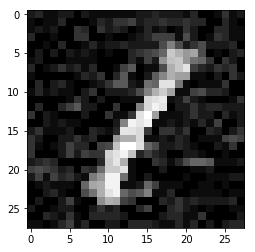

In [12]:
import matplotlib.pyplot as plt
plt.imshow(adv_images[3].reshape(-1,28), cmap='gray')
plt.show()

In [13]:
adv = tf.placeholder(tf.float32, [None, 28, 28, 1], name="adv")
_, output_adv = model.basic_cnn(adv, reuse=True)

correct_prediction2 = tf.equal(tf.argmax(output_adv, -1), tf.argmax(target_class, -1))
accuracy2 = tf.reduce_mean(tf.cast(correct_prediction2, "float"))
print("test accuracy %g" %accuracy2.eval(session=sess, feed_dict={adv:adv_images}))

test accuracy 0.9944


# Learn a surragate ATM

In [14]:
def surrogate_generator(inputs, reuse=False):
    with tf.variable_scope("surrogate_generator", reuse=reuse) as scope:
        x = conv2d(inputs, 32,5,5,1,1, name='conv1')
        x = conv2d(x, 16,1,1,1,1, name='bottleconv')
        x = conv2d(x, 16,3,3,1,1, name='conv2')
        x = conv2d(x, 32,1,1,1,1, name='conv3')
        x = slim.flatten(x, scope='flatten')
        xl = slim.fully_connected(x, 784, activation_fn=None, scope='fc')
        xl = tf.reshape(xl,[-1,28,28,1])
        # xl = linear(x, 1, scope='fc')
        xl = inputs + xl
        xp = tf.nn.tanh(xl)
        x_logits = slim.fully_connected(slim.dropout(x, 0.5), 10, activation_fn=None, scope='fc2')
        x_logits = tf.nn.softmax(x_logits, name="softmax")
        # xl = tf.reshape(xl,[-1,28,28,1])
        return x_logits, xp

# define model
_xr  = tf.placeholder(tf.float32, [None, 28, 28, 1], name="xr")
_adv = tf.placeholder(tf.float32, [None, 28, 28, 1], name="adv")
_y   = tf.placeholder(tf.float32, [None, 10])

gen_adv_logits, gen_adv = surrogate_generator(_xr)

_loss_label = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=gen_adv_logits, labels=_y))
_loss_image = tf.reduce_mean(tf.square(_adv - gen_adv))
_total_loss = tf.add(_loss_label, _loss_image)

# learning rate
_global_step = tf.Variable(0, trainable=False)   
_lr_decayed = tf.train.exponential_decay(0.001, _global_step, 2*10000, 0.1, staircase=False)

# variable list
_all_var = tf.global_variables()
_g_vars = [var for var in _all_var if 'generator' in var.name]
# optimizer
_G_optimizer = tf.train.AdamOptimizer(learning_rate=_lr_decayed).minimize(_total_loss, var_list=[_g_vars])

In [17]:
# sess = tf.Session()
sess.run(tf.global_variables_initializer())
# sess.run(tf.tables_initializer())

target_label = sess.run(target_class)

# BATCH_SIZE = 128
_total_batch = int(60000 / BATCH_SIZE)
# T_loss = open('out/acc_loss/fixed_total_loss.txt','w+')
# D_loss = open('out/acc_loss/fixed_r_loss.txt','w+')
# G_loss = open('out/acc_loss/fixed_p_loss.txt','w+')
for epoch in range(80):
    for i in range(_total_batch):
        bstart, bend = i*BATCH_SIZE, (i+1)*BATCH_SIZE
        batch_xr, batch_xp = xr_train[bstart:bend], adv_images[bstart:bend]
        batch_y = np.repeat(target_label, BATCH_SIZE, axis=0)

        _, G_loss_curr, _loss_l, _loss_i = sess.run([_G_optimizer, _total_loss, _loss_label, _loss_image],
                                  feed_dict={_xr: batch_xr,
                                             _adv: batch_xp,
                                             _y: batch_y})
        if i % 1000 == 0:
            print(G_loss_curr, _loss_l, _loss_i)
#     T_loss.write(str(t_loss)+'\n')
#     D_loss.write(str(temp_loss1)+'\n')
#     G_loss.write(str(temp_loss2)+'\n')
# T_loss.close()
# D_loss.close()
# G_loss.close()

2.325075 2.3025851 0.02248982
1.4745941 1.46122 0.013374127
1.4744276 1.4612198 0.013207832
1.4743084 1.4612073 0.013101152
1.4742287 1.4611992 0.013029584
1.4741738 1.4611955 0.012978309
1.4741235 1.4611905 0.012933035
1.4740702 1.4611893 0.0128808655
1.4739826 1.4611781 0.012804533
1.4738605 1.461169 0.012691489
1.4737394 1.4611676 0.012571792
1.4736406 1.461169 0.012471572
1.4735799 1.4611709 0.012408935
1.47354 1.461173 0.012366916
1.4735221 1.4611664 0.012355667
1.4734994 1.4611703 0.012329061
1.4734455 1.4611775 0.012268075
1.4734057 1.4611773 0.012228326
1.4733716 1.461183 0.012188629
1.4733448 1.4611871 0.012157711
1.473311 1.4611813 0.012129608
1.4732903 1.461183 0.012107428
1.4732721 1.4611847 0.012087341
1.4732438 1.4611753 0.012068481
1.4732038 1.4611676 0.012036223
1.4731714 1.4611663 0.012005046
1.4731394 1.4611759 0.011963477
1.4730768 1.4611688 0.011908039
1.4730173 1.461165 0.011852349
1.4729915 1.4611653 0.011826141
1.4729574 1.4611666 0.011790788
1.4728998 1.4611603 

In [18]:
_xin = tf.placeholder(tf.float32, [None, 28, 28, 1], name="xin")
# _y  = tf.placeholder(tf.float32, [None, 10])
target_label = sess.run(target_class)

_gen_adv_logits, _gen_adv = surrogate_generator(_xin, reuse=True)

# g_sample = sess.run(_gen_adv, feed_dict={_xin: xr_test[0].reshape(-1,28,28,1)})
# plt.imshow(g_sample.reshape(-1,28))

# calculate accuracy
_correct_prediction = tf.equal(tf.argmax(_gen_adv_logits, axis=-1), tf.argmax(target_class, axis=-1))
_accuracy_fake = tf.reduce_mean(tf.cast(_correct_prediction, "float"))

print("fixed adversarial accuracy %g" %_accuracy_fake.eval(session=sess, feed_dict={_xin: xr_test}))

fixed adversarial accuracy 1


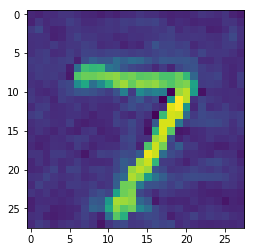

In [19]:
g_sample = sess.run(_gen_adv, feed_dict={_xin: xr_test[0].reshape(-1,28,28,1)})
plt.imshow(g_sample.reshape(-1,28))

## save data as tfrecord

In [15]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [16]:
with tf.Session() as session:
    target_label = session.run(target_class)

In [17]:
filename = "./out/adv_fixed_mnist.tfrecords"
writer = tf.python_io.TFRecordWriter(filename)
for i in range(50000):
    images_raw = adv_images[i].tostring()
    example = tf.train.Example(features=tf.train.Features(feature={
        'label': _int64_feature(np.argmax(target_label)),
        'image': _bytes_feature(images_raw)}))
    writer.write(example.SerializeToString())
writer.close()

In [22]:
# from PIL import Image

# for i in range(50000):
#     im = adv_images[i].reshape(28,28)
#     img= Image.fromarray(im*255)
#     img = img.convert('RGB')
#     img.save('out/adversarial/fixed/3/adv_%s.png'%i,'png')

## Manual calculation (TODO)
we can use FGSM method which written by ourselves to generate adversarial examples

In [ ]:
def step_fgsm(x, eps, logits):
    label = tf.argmax(logits,1)
    one_hot_label = tf.one_hot(label, NUM_CLASSES)
    cross_entropy = tf.losses.softmax_cross_entropy(one_hot_label,
                                                  logits,
                                                  label_smoothing=0.1,
                                                  weights=1.0)
    x_adv = x + eps*tf.sign(tf.gradients(cross_entropy,x)[0])
    x_adv = tf.clip_by_value(x_adv,-1.0,1.0)
    return tf.stop_gradient(x_adv)
 
def step_targeted_attack(x, eps, one_hot_target_class, logits):
    #one_hot_target_class = tf.one_hot(target, NUM_CLASSES)
    #print(one_hot_target_class,"\n\n")
    cross_entropy = tf.losses.softmax_cross_entropy(one_hot_target_class,
                                                  logits,
                                                  label_smoothing=0.1,
                                                  weights=1.0)
    x_adv = x - eps * tf.sign(tf.gradients(cross_entropy, x)[0])
    x_adv = tf.clip_by_value(x_adv, -1.0, 1.0)
    return tf.stop_gradient(x_adv)

def step_ll_adversarial_images(x, eps, logits):
    least_likely_class = tf.argmin(logits, 1)
    one_hot_ll_class = tf.one_hot(least_likely_class, NUM_CLASSES)
    one_hot_ll_class = tf.reshape(one_hot_ll_class,[1,NUM_CLASSES])
    # This reuses the method described above
    return step_targeted_attack(x, eps, one_hot_ll_class, logits)

In [ ]:
softmax_tensor = sess.graph.get_tensor_by_name('discriminator/fc2/add:0')
image_tensor = sess.graph.get_tensor_by_name('xr:0')
target_class = tf.reshape(tf.one_hot(2,NUM_CLASSES),[1,NUM_CLASSES])

adv_image_tensor = step_targeted_attack(image_tensor, fgsm_params['eps'], target_class, softmax_tensor)
adv_image = xr_train[0].reshape(-1,28,28,1)
t = adv_image.copy()
adv_noise = np.zeros(t.shape)
# for j in range(100):
j=0
adv_image = xr_train[j].reshape(-1,28,28,1)
if j%2000==0:
    print("Iteration "+str(j))
for i in range(it):
    #print("Iteration "+str(i))
    adv_image = sess.run(adv_image_tensor,{'xr:0': adv_image})
adv_noise = np.concatenate((adv_noise, adv_image))
#plt.imshow(adv_image.reshape(-1,28))

In [ ]:
plt.imshow(adv_image[0].reshape(-1,28))

test accuracy

In [ ]:
adv = tf.placeholder(tf.float32, [None, 28, 28, 1], name="adv")
output_logits_adv, output_adv = model.basic_cnn(adv, reuse=True)

correct_prediction2 = tf.equal(tf.argmax(output_adv, -1), tf.argmax(target_class, -1))
accuracy2 = tf.reduce_mean(tf.cast(correct_prediction2, "float"))
print("test accuracy %g" %accuracy2.eval(session=sess, feed_dict={adv:adv_images}))

In [11]:
%whos

Variable              Type             Data/Info
------------------------------------------------
BATCH_SIZE            int              128
CIFAR10               type             <class 'cleverhans.dataset.CIFAR10'>
CNN                   type             <class 'model.CNN'>
CarliniWagnerL2       type             <class 'cleverhans.attacks.CarliniWagnerL2'>
D_loss                TextIOWrapper    <_io.TextIOWrapper name='<...>de='w+' encoding='UTF-8'>
FastGradientMethod    type             <class 'cleverhans.attacks.FastGradientMethod'>
G_loss                TextIOWrapper    <_io.TextIOWrapper name='<...>de='w+' encoding='UTF-8'>
MNIST                 type             <class 'cleverhans.dataset.MNIST'>
MyModel               type             <class 'model.MyModel'>
NB_EPOCHS             int              100
T_loss                TextIOWrapper    <_io.TextIOWrapper name='<...>de='w+' encoding='UTF-8'>
accuracy1             Tensor           Tensor("Mean_3:0", shape=(), dtype=float32)
accur